# Tutorial 2 - Car Prices & Linear Regression

**Course:** SYSC 4415 - Intro to Machine Learning

**Semester:** Winter 2023

**Adapted From:** https://sungsoo.github.io/2018/04/11/predicting-car-prices.html and Kevin Dick's tutorial

---

In this notebook we will explore the process of:
1. loading tabular data
2. examining raw variables
3. transforming variables
4. exploratory data analysis (EDA)
5. building linear regression model (regression)
6. building a logistic regression model (classification)

This is an example of *predictive analytics* using a dataset that most people can relate to: **prices of a car**!

In the data set, we find the following eight variables:

* *(Int)* Price 
* *(Int)* Age 
* *(Int)* KM (kilometers driven)
* *(String)* Fuel Type
* *(Int)* HP(horsepower)
* *(Bool)* Automatic or Manual
* *(Int)* Number of Doors
* *(Bool)* Metallic Colour
* *(Int)* CC (total volume of air and fuel being pushed through the engine by the cylinders in cubic centimeters)
* *(Int)* Weight(in pounds)

Data for 1,436 vehicles are collected in a CSV file for a single type of vehicle: the _Toyota Corolla_. You can download this dataset from the original author's github account here: https://github.com/datailluminations/PredictingToyotaPricesBlog

### The Target Varriable
In **predictive models**, there is a response variable (also called dependent variable or **target variable**), which is the variable that we are interested in predicting.

### The Features
The **independent variables** (the predictors, also called **features** in the machine learning community) are one or more numeric variables we are using to predict the response variable. Given we are using a linear regression model, we are assuming the relationship between the independent and dependent variables follow a straight line. Later, one could examine more complex models to see if it improves predictive powers.

# 1. Loading Tabular Data

In [ ]:
# First load up any packages we will need!
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
import seaborn as sb

Note: If you are missing certain packages, you can use **pip** within the command line to install them!
If using Google's Collab, you can use a cell with a leading exclamation point to execute shell commands. For example: 
`!pip install pandas`

In [ ]:
# data source & load into a dataframe
file_path = 'https://raw.githubusercontent.com/datailluminations/PredictingToyotaPricesBlog/master/ToyotaCorolla.csv'
car_data = pd.read_csv(file_path)

# set the column headers
df = pd.DataFrame(car_data, columns= ['Price', 'Age', 'KM', 'FuelType', 'HP', 'MetColor', 'Automatic', 'CC', 'Doors', 'Weight'])

# (optional) unpack columns into individual variables
price     = df['Price']
age       = df['Age']
km        = df['KM']
fuelType  = df['FuelType']
hp        = df['HP']
metColor  = df['MetColor']
automatic = df['Automatic']
cc        = df['CC']
doors     = df['Doors']
weight    = df['Weight']

df.head()

,Price,Age,KM,FuelType,HP,MetColor,Automatic,CC,Doors,Weight
0,13500,23,46986,Diesel,90,1,0,2000,3,1165
1,13750,23,72937,Diesel,90,1,0,2000,3,1165
2,13950,24,41711,Diesel,90,1,0,2000,3,1165
3,14950,26,48000,Diesel,90,0,0,2000,3,1165
4,13750,30,38500,Diesel,90,0,0,2000,3,1170


# 2. Examine Raw Variables

Before we start the modeling exercise, it’s good to take a visual look at what we are trying to predict to see what it looks like. Since we are **trying to predict Toyota Corolla prices with historical data**, we can create simple histogram plots to examine the distribution of Corolla prices (or another variable of our choosing):

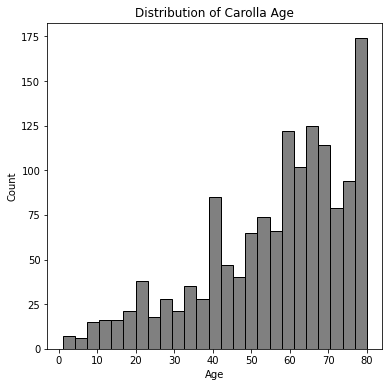

In [ ]:
# Change this variable to the one we are interested in plotting (why does FuelType throw an error?)
var2plot = 'Age' # 'Age', 'KM', 'FuelType', 'HP', 'MetColor', 'Automatic', 'CC', 'Doors', 'Weight'

plt.figure(figsize= (6,6))
plt.hist(df[var2plot], bins=25, color= 'grey', edgecolor= 'black')
plt.xlabel(var2plot)
plt.ylabel("Count")
plt.title(f"Distribution of Carolla {var2plot}")
plt.show()

In [ ]:
# We can also examine the summary statistics for each feature (note that categorical features aren't present)
df.describe()

,Price,Age,KM,HP,MetColor,Automatic,CC,Doors,Weight
count,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.00000
mean,10730.824513,55.947075,68533.259749,101.502089,0.674791,0.055710,1566.827994,4.033426,1072.45961
std,3626.964585,18.599988,37506.448872,14.981080,0.468616,0.229441,187.182436,0.952677,52.64112
min,4350.000000,1.000000,1.000000,69.000000,0.000000,0.000000,1300.000000,2.000000,1000.00000
25%,8450.000000,44.000000,43000.000000,90.000000,0.000000,0.000000,1400.000000,3.000000,1040.00000
50%,9900.000000,61.000000,63389.500000,110.000000,1.000000,0.000000,1600.000000,4.000000,1070.00000
75%,11950.000000,70.000000,87020.750000,110.000000,1.000000,0.000000,1600.000000,5.000000,1085.00000
max,32500.000000,80.000000,243000.000000,192.000000,1.000000,1.000000,2000.000000,5.000000,1615.00000


We see that most used Corollas cost around 10K and there are some at the tail end that over 25K (possibly newer cars).

# 3. Data Transformation

One of the main steps in the predictive analytics is data transformation. Data is **seldom arranged in the way you want them**. 

One might have to do some kinds of transformations to get it to the way we need them to be either because the data is dirty, not of the type we want, out of bounds, and a host of other reasons.

### Catagorical Variable --> Numerical Variable
In this case, we need to convert the categorical variables to numeric variables to feed into our linear regression model, because **linear regression models only take numeric variables**.

The categorical variable we want to do the transformation on is **Fuel Types**. We note that there are 3 Fuel Types:
1. CNG 
2. Diesel 
3. Petrol

Let's first count how many there are of each and then encode this into a numerical format!

In [ ]:
# print out all of the unique fuelType categories
print(fuelType.unique())

# count the number of instances of each (summation of the subset for each; a value of 1 for each TRUE instance)
num_cng    = np.sum(fuelType == "CNG")
num_diesel = np.sum(fuelType == "Diesel")
num_petrol = np.sum(fuelType == "Petrol")
print(f"CNG:\t{num_cng}\nDiesel:\t{num_diesel}\nPetrol:\t{num_petrol}")

['Diesel' 'Petrol' 'CNG']
CNG:	17
Diesel:	155
Petrol:	1264


So, we can convert the categorical variable Fuel Type to *two numeric variables*: **FuelType1** and **FuelType2**. 

We assign CNG to a new variable FuelType1 in which a 1 represents it’s a CNG vehicle and 0 it’s not. 
Likewise, we assign Diesel to a new variable FuelType2 in which a 1 represents it’s a Diesel vehicle and 0 it’s not.

So, what do we do with PETROL vehicles? We could have introduced a third varialbe (e.g. FuelType3), but here we will represent PETROL by the case when BOTH FuelType1 and FuelType2 are zero.

In [ ]:
# convert categorical variables to integer so we can use in our model
fuelType1 = (fuelType == "CNG")* 1  # multiple by 1 to ensure numeric representation True* 1 = 1, False* 1= 0
fuelType2 = (fuelType == "Diesel")* 1

# Add these new variables to our DataFrame
df["FuelType1"] = fuelType1
df["FuelType2"] = fuelType2
print(df.head())

   Price  Age     KM FuelType  HP  MetColor  Automatic    CC  Doors  Weight  \
0  13500   23  46986   Diesel  90         1          0  2000      3    1165   
1  13750   23  72937   Diesel  90         1          0  2000      3    1165   
2  13950   24  41711   Diesel  90         1          0  2000      3    1165   
3  14950   26  48000   Diesel  90         0          0  2000      3    1165   
4  13750   30  38500   Diesel  90         0          0  2000      3    1170   

   FuelType1  FuelType2  
0          0          1  
1          0          1  
2          0          1  
3          0          1  
4          0          1  


# 4. Exploratory Data Analysis (EDA):

The next step in predictive analytics is to explore our underlying data structure. 

Let’s do a few plots of our explantory variables to see how they look against `Price`.

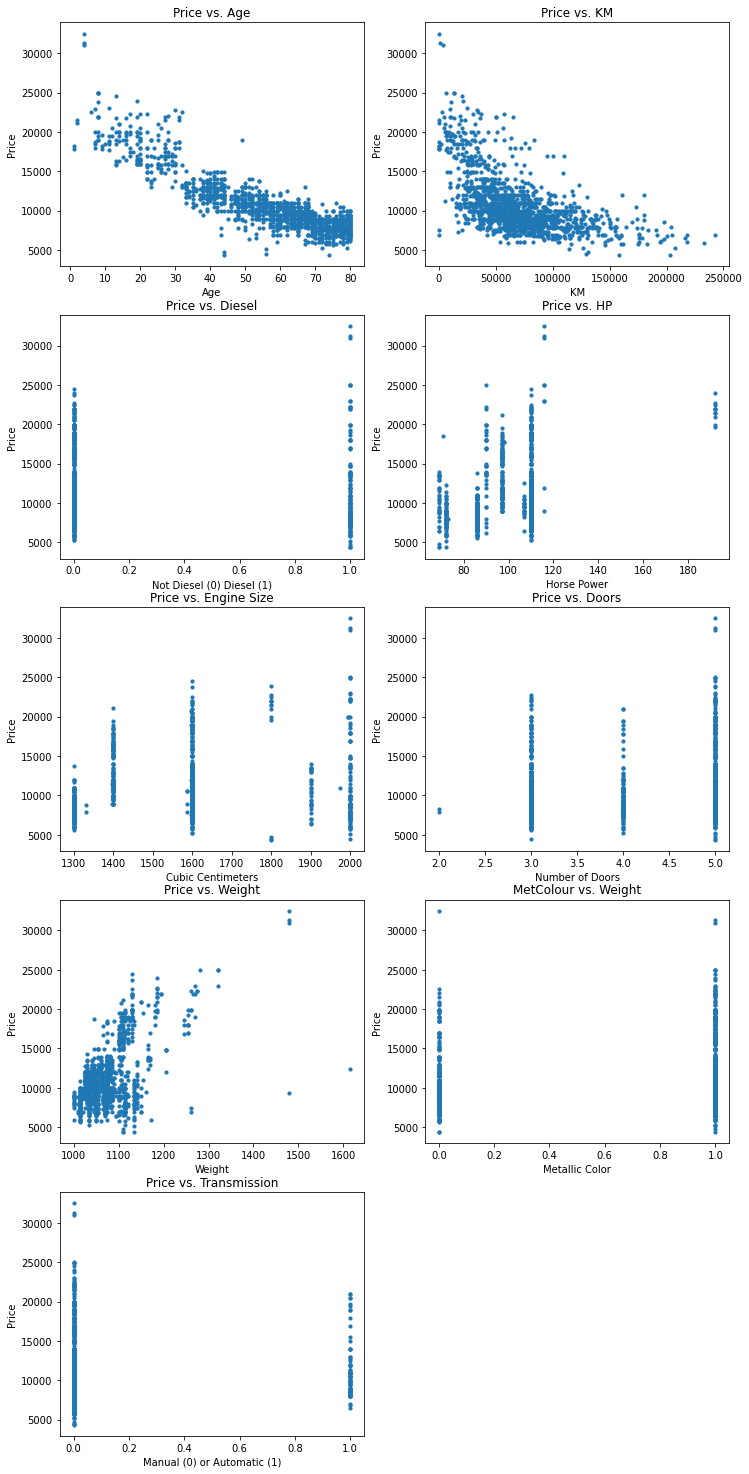

In [ ]:
# plot variables against price
plt.figure(figsize= (12,26))

plt.subplot(5, 2, 1); plt.scatter(age, price, s=10); plt.xlabel("Age"); plt.ylabel("Price"); plt.title("Price vs. Age")
plt.subplot(5, 2, 2); plt.scatter(km, price, s=10); plt.xlabel("KM"); plt.ylabel("Price"); plt.title("Price vs. KM")
plt.subplot(5, 2, 3); plt.scatter(fuelType2, price, s=10); plt.xlabel("Not Diesel (0) Diesel (1)"); plt.ylabel("Price"); plt.title("Price vs. Diesel")
plt.subplot(5, 2, 4); plt.scatter(hp, price, s=10); plt.xlabel("Horse Power"); plt.ylabel("Price"); plt.title("Price vs. HP")
plt.subplot(5, 2, 5); plt.scatter(cc, price, s=10); plt.xlabel("Cubic Centimeters"); plt.ylabel("Price"); plt.title("Price vs. Engine Size")
plt.subplot(5, 2, 6); plt.scatter(doors, price, s=10); plt.xlabel("Number of Doors"); plt.ylabel("Price"); plt.title("Price vs. Doors")
plt.subplot(5, 2, 7); plt.scatter(weight, price, s=10); plt.xlabel("Weight"); plt.ylabel("Price"); plt.title("Price vs. Weight")
plt.subplot(5, 2, 8); plt.scatter(metColor, price, s=10); plt.xlabel("Metallic Color"); plt.ylabel("Price"); plt.title("MetColour vs. Weight")
plt.subplot(5, 2, 9); plt.scatter(automatic, price, s=10); plt.xlabel("Manual (0) or Automatic (1)"); plt.ylabel("Price"); plt.title("Price vs. Transmission")
plt.show()

From these plots, we can obtain a few insights: 

* (Age) **Newer cars** tend to be **more expensive** (as expected)
* (KM) The **more miles** a car has the **cheaper** it is.
* (HP) Horsepower - this one is not as direct as the other. Yes, the more horsepower the more expensive. But not always the case. Let’s see how this variable will behave in our model.
* (Metcolor) The fact that a color has a **Metallic Color** or not **doesn’t seem to be that useful**. But let’s see what the model says...
* (automatic) **Transmission type** does not have much of an influence on the **prices**.
* (CC) The **engine size** plots against price seems to show the **larger engines** tend to be **more expensive** though not always the case.
* (doors) Plotting number of doors does not tell us much.
* (weight) The heavier(i.e. bigger) cars cost more though there are some outliers that doesn’t fit nicely.

When working on a new problem with tabular data, the insights from EDA help in building a "story" about the data and develop an intuition for how certain variables relate to others.

# 5. Model Building - Linear Regression

Now that we have explored our variables, let’s perform a simple linear regression of `Price` against all the data we’ve collected.

In [ ]:
# setup foor a linear regression (we MUST remove the dependent variable from the features)
x  = df[['Age', 'KM', 'HP', 'MetColor', 'Automatic', 'CC', 'Doors', 'Weight', 'FuelType1', 'FuelType2']] # features/independent variables
x  = sm.add_constant(x)   # Recall that sm is 'statsmodels.api'
y1 = df['Price']        # our dependent variable

# fit our linear regression model
model1 = sm.OLS(y1, x).fit()

# apply trained/learned model back to training data
pred1 = model1.predict(x)  

# print summary stats from model fit
print(model1.summary())  

# The predictions are listed in pred1 in order
# print(pred1)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     948.0
Date:                Thu, 02 Feb 2023   Prob (F-statistic):               0.00
Time:                        17:04:49   Log-Likelihood:                -12346.
No. Observations:                1436   AIC:                         2.471e+04
Df Residuals:                    1425   BIC:                         2.477e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2680.6851   1219.030     -2.199      0.0

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### Model Interpretation

We see from the output that our model captures **86.9% (see Multiple R square) of the variation** in `price` using the explantory variables above. This is pretty decent.

However, we notice is that **some coefficents are more statistically significant than others**. 

For example, we find that `Age` is the **most significant** witha t-value of -46.889, followed by `Weight` with a t-value of 16.629. 

The **least significant variables** are `Metallic Color` and `Number of Doors`. This was also confirmed in our EDA (exploratory data analysis) graphs above.

### Correcting the Data Split
Now, it’s generally **NOT a good idea to use your ENTIRE data sample to fit the model**. 

What we want to do is to **train the model on a sample of the data**. 
Then we’ll **see how it perform outside of our training sample**. 

This breaking up of our data set into a **training set** and **test set** to evaluate the performance of our models with _unseen data_. Using the entire data set to build a model then using the entire data set to evaluate how good a model does is a bit of cheating or careless analytics.

### Results with Training Data:

Here we will use the first 1,000 rows (of 1,436 iinstances; ~2/3) as our training set:

In [ ]:
x  = df[['Age', 'KM', 'HP', 'MetColor', 'Automatic', 'CC', 'Doors', 'Weight', 'FuelType1', 'FuelType2']]
y1 = df['Price']

# take first 1000 samples of independent variables as training set
trainX = x[0:1000]  
trainX = sm.add_constant(trainX) # add constant
trainY = y1[0:1000] # take first 1000 samples of price as well as training set

# Train model on training data
model2 = sm.OLS(trainY, trainX).fit()
trainingResults = model2.predict(trainX) # Evaluate model on training set
 
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     628.8
Date:                Thu, 02 Feb 2023   Prob (F-statistic):               0.00
Time:                        17:04:57   Log-Likelihood:                -8649.8
No. Observations:                1000   AIC:                         1.732e+04
Df Residuals:                     989   BIC:                         1.738e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2916.5288   1447.024     -2.016      0.0

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### Model Interpretation

Interesting enough, the **R-squared only changed nominally to 86.4%** and the variables **t-value also moved slightly**. The **statistically significant relationships remained the same**. Good1

### Model Evaluation: Linear Regression

The real test of a good model is to **test the model with data that it has not been fitted**. Here’s where the rubber meets the road. We apply our model to unseen data to see how it performs.

### Prediction using out-of-sample data

Here are some common metrics to see how well the model predicts using various error metrics. 
The main takeway is we **want our forecast errors to be as small as possible**. The smaller the forecast error the better the model is at predicting unseen data.

#### Metric 1: Mean Absolute Error (MAE)
The first metric is **mean absolute error (MAE)**: the average absolute value of the error observed over all test points. The smaller the better!

$\left ( \frac{1}{n} \right) \sum_{i=1}^{n}\left | y_{i} - \hat{y_{i}}\right |$

In [ ]:
testX= x[1000:]  # take the remaining samples of independent variables for testing set
testX = sm.add_constant(testX) # add constant
testY= y1[1000:] # take the remaining samples of price as well for testing set

testingResults = model2.predict(testX) # results of trained model on new data
#print(testingResults)

# mean absolute error
mae = sm.tools.eval_measures.meanabs(testY, testingResults)
print("mean absolute error: %.2f" % mae)

mean absolute error: 988.87


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


The **ideal MAE is zero**, which means on average the **predicted value perfectly matches the actual value**. This is rarely if ever the case. 

As in all things, we must determine what is an acceptable level of errors for our predictive analytics model and accept it. No such thing as a perfect model!

#### Metric 2: Root Mean Squared Error (RMSE)
The second metric is **root mean squared error (RMSE)**: the average of the squared differences between the predicted value and the actual value. 

The reason we square is to not account for sign differences(negative differences and positive differences are the same thing when squared). RMSE brings it back to our normal unit by taking the square root of MSE.

$ \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big( y_i - \hat{y_i}\Big)^2}}$

In [ ]:
# root mean squared error
rmse= sm.tools.eval_measures.rmse(testY, testingResults)
print("root mean squared error: %.2f" % rmse)

root mean squared error: 1260.63


In [ ]:
# Now, in PyTorch!!!

In [ ]:
import random
import torch
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
def normalize(x):
    x_normed = (x - x.min()) / (x.max() - x.min())
    return x_normed

def build_cars_dataset(input_names, output_names, split_location=1000, num_datapoints=1436, normalize_features=True):
    # First, lets put all of our data in a tensor
    all_feature_vectors = []
    for idx in range(num_datapoints):
        feature_vector = []
        for input_name in input_names:
            feature = df[input_name][idx]
            feature_vector.append(feature)

        for output_name in output_names:
            feature = df[output_name][idx]
            feature_vector.append(feature)
        
        feature_vector = torch.Tensor(feature_vector).unsqueeze(dim=0)  # (1, num_features)
        all_feature_vectors.append(feature_vector)

    # random.shuffle(all_feature_vectors)  # randomly shuffle rows
    all_feature_vectors = torch.cat(all_feature_vectors, dim=0)  # (num_datapoints, num_features)

    print(f'Chosen inputs: {input_names}')
    print(f'Chosen outputs: {output_names}')
    print(f'All data shape: {all_feature_vectors.shape}')

    if normalize_features:
        # normalize (squish between 0 and 1) each feature independently
        for feature_idx in range(all_feature_vectors.shape[-1]):
            all_feature_vectors[:, feature_idx] = normalize(all_feature_vectors[:, feature_idx])

    # Next, lets split up data into train, test
    train_inputs = all_feature_vectors[:split_location, :len(input_names)]  # (num_train, num_inputs)
    train_labels = all_feature_vectors[:split_location, len(input_names):]  # (num_train, num_outputs)

    test_inputs = all_feature_vectors[split_location:, :len(input_names)]  # (num_test, num_inputs)
    test_labels = all_feature_vectors[split_location:, len(input_names):]  # (num_test, num_outputs)

    print(f'Train inputs shape: {train_inputs.shape}, train labels shape: {train_labels.shape}')
    print(f'Test inputs shape: {test_inputs.shape}, test labels shape: {test_labels.shape}')  

    train_dataset = TensorDataset(train_inputs, train_labels)
    test_dataset = TensorDataset(test_inputs, test_labels)

    return train_dataset, test_dataset

In [ ]:
cars_train_dataset, cars_test_dataset = build_cars_dataset(
    input_names=['Age', 'KM', 'HP', 'MetColor', 'Automatic', 'CC', 'Doors', 'Weight', 'FuelType1', 'FuelType2'],
    output_names=['Price'],
    normalize_features=True
    )

cars_train_loader = DataLoader(cars_train_dataset, batch_size=32, shuffle=True)
cars_test_loader = DataLoader(cars_train_dataset, batch_size=32, shuffle=False)

Chosen inputs: ['Age', 'KM', 'HP', 'MetColor', 'Automatic', 'CC', 'Doors', 'Weight', 'FuelType1', 'FuelType2']
Chosen outputs: ['Price']
All data shape: torch.Size([1436, 11])
Train inputs shape: torch.Size([1000, 10]), train labels shape: torch.Size([1000, 1])
Test inputs shape: torch.Size([436, 10]), test labels shape: torch.Size([436, 1])


In [ ]:

for learning_rate in [1e-3]:
    model = torch.nn.Linear(10, 1)
    opt = torch.optim.SGD(model.parameters(), learning_rate)
    num_epochs = 200

    for epoch in range(num_epochs):
        train_losses = []
        for batch in cars_train_loader:
            batch_input = batch[0]  # (batch_size, num_input_features)
            batch_output = batch[1]  # (batch_size, num_outputs_labels)

            out = model(batch_input)  # (batch_size, num_outputs_labels)
            loss = torch.nn.functional.mse_loss(out, batch_output)
            train_losses.append(loss.item())

            loss.backward()  # calculate gradients of every model parameter
            opt.step()  # use our optimizer to update model parameters
            opt.zero_grad()  # set gradients back to zero

            # below is the code to "manually" update parameters
            # for param in model.parameters():
            #     param.data = param.data - (param.grad * learning_rate)  # update parameters via SGD
            #     param.grad = torch.zeros_like(param.grad)  # reset gradients

        if (epoch+1) % 10 == 0:
            # after every epoch lets calculate our test loss
            y_hat = []
            y = []
            with torch.no_grad():
                for batch in cars_test_loader:
                    batch_input = batch[0]  # (batch_size, num_input_features)
                    batch_output = batch[1]  # (batch_size, num_outputs_labels)

                    out = model(batch_input)  # (batch_size, num_outputs_labels)
                    y_hat.append(out)
                    y.append(batch_output)

            y_hat = torch.cat(y_hat, dim=0)
            y = torch.cat(y, dim=0)
            test_loss = torch.nn.functional.mse_loss(y_hat, y).item()

            train_loss_mean = torch.Tensor(train_losses).mean().item()
            print(f'Epoch: {epoch+1},  train loss: {train_loss_mean},  test loss: {test_loss}')
        
    print('\n')
    # print(test_loss, learning_rate)

    # below, lets print out the learned model parameters
    # state_dict = model.state_dict()
    # for p in state_dict:
    #     print(p, state_dict[p])
    # print('\n')


Epoch: 10,  train loss: 0.050965581089258194,  test loss: 0.051436897367239
Epoch: 20,  train loss: 0.04751309007406235,  test loss: 0.04664640873670578
Epoch: 30,  train loss: 0.04262989014387131,  test loss: 0.04304090887308121
Epoch: 40,  train loss: 0.04223066195845604,  test loss: 0.03989147022366524
Epoch: 50,  train loss: 0.037153199315071106,  test loss: 0.03712695464491844
Epoch: 60,  train loss: 0.034471847116947174,  test loss: 0.03466400131583214
Epoch: 70,  train loss: 0.032558098435401917,  test loss: 0.03247910365462303
Epoch: 80,  train loss: 0.030657446011900902,  test loss: 0.030502110719680786
Epoch: 90,  train loss: 0.028541158884763718,  test loss: 0.028733836486935616
Epoch: 100,  train loss: 0.027729248628020287,  test loss: 0.02712170220911503
Epoch: 110,  train loss: 0.02631140500307083,  test loss: 0.02567256987094879
Epoch: 120,  train loss: 0.024250950664281845,  test loss: 0.024328891187906265
Epoch: 130,  train loss: 0.02305818907916546,  test loss: 0.0231